In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset paths
train_dir = "C:/Users/krish/SignLanguageInterpretation/asl_alphabet_train/train"
val_dir = "C:/Users/krish/SignLanguageInterpretation/asl_alphabet_train/val"
test_dir = "C:/Users/krish/SignLanguageInterpretation/asl_alphabet_train/test"

# Image preprocessing
img_width, img_height = 64, 64
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode="categorical"
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode="categorical"
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(img_width, img_height), batch_size=batch_size, class_mode="categorical", shuffle=False
)


Found 60900 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.


In [3]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Load MobileNetV3 with imagenet weights (exclude top layers)
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Open base layers
base_model.trainable = True

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.1),
    layers.Dense(29, activation="softmax"),  # 29 classes (A-Z, space, delete, nothing)
])

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


# Define callbacks
callbacks = [
    # Stop training early if validation loss stops improving
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    
    # Save the best model based on validation accuracy
    # ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy'),
    
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

model.summary()

C:\Users\krish\anaconda3\Lib\site-packages\keras\src\applications\mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)        │ (None, 2, 2, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         246,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           7,453 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,249,821 (12.40 MB)

 Trainable params: 3,225,421 (12.30 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [6]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)

# Save the model
model.save("asl_alphabet_model_MobileNetV3_Callback_LayerTrainable_DropOut-0.1_epoch40.keras")


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.0576 - loss: 3.7508

C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 320s 157ms/step - accuracy: 0.0577 - loss: 3.7506 - val_accuracy: 0.0583 - val_loss: 3.7431 - learning_rate: 1.0000e-05
Epoch 2/40
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/40


C:\Users\krish\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
C:\Users\krish\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
C:\Users\krish\anaconda3\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 341s 179ms/step - accuracy: 0.1890 - loss: 2.9098 - val_accuracy: 0.0539 - val_loss: 4.2896 - learning_rate: 1.0000e-05
Epoch 4/40
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 5/40
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 389s 204ms/step - accuracy: 0.3310 - loss: 2.2994 - val_accuracy: 0.1172 - val_loss: 3.8004 - learning_rate: 1.0000e-05
Epoch 6/40
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 7/40
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 411s 216ms/step - accuracy: 0.4640 - loss: 1.7836 - val_accuracy: 0.5604 - val_loss: 1.4633 - learning_rate: 1.0000e-05
Epoch 8/40
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 9/40
1904/1904 ━━━━━━━━━━━━━━━━━━━━ 649s 341ms/step - accuracy: 0.5744 - loss: 1.3710 - val_accuracy: 0.6997 - val_loss: 0.9672 - learning_rate:

In [22]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

408/408 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9829 - loss: 0.0524
Test Accuracy: 98.41%


In [26]:
model.save('mobileNetV2.keras')

408/408 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step


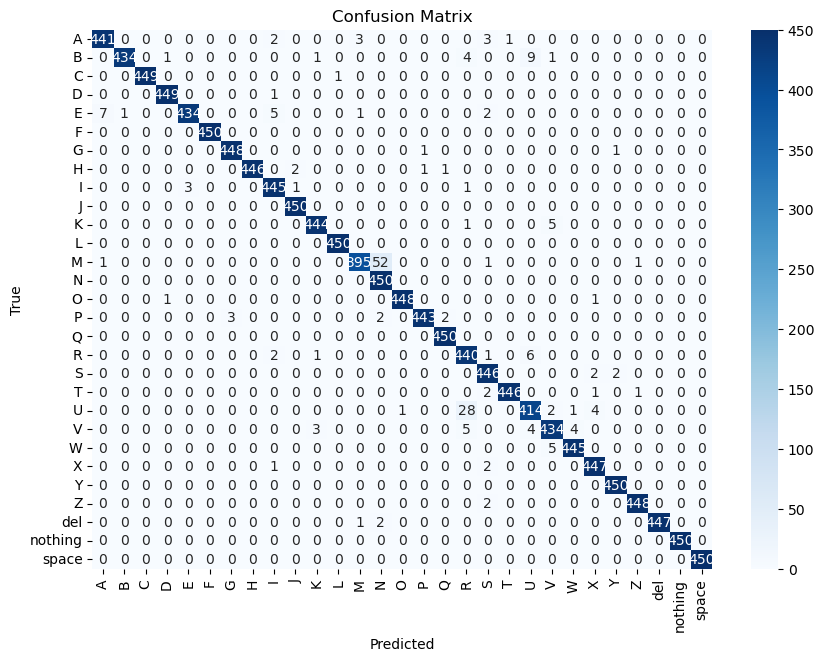

In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


408/408 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step


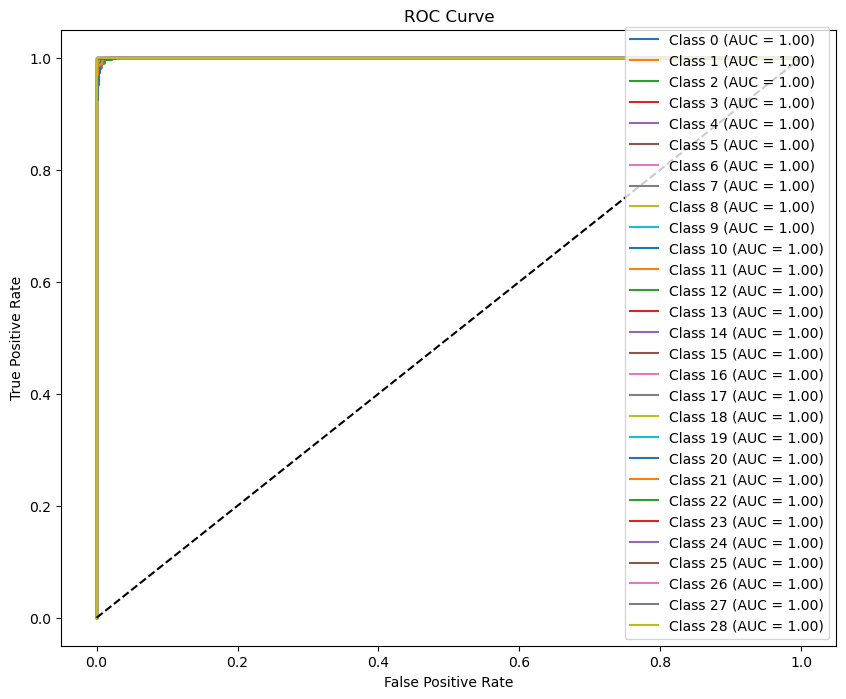

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict(test_generator)
n_classes = len(test_generator.class_indices)

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_preACd_classes, target_names=test_generator.class_indices.keys()))

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Get image file paths and labels
image_paths = []
labels = []

# Reverse class indices dictionary
class_names = list(test_generator.class_indices.keys())

# Populate image_paths and labels
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    for img in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img))
        labels.append(class_name)  # Append the class name (string), not the index

image_paths = np.array(image_paths)
labels = np.array(labels)

# Define Stratified K-Fold
k = 10  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# K-Fold Cross-Validation Loop
fold = 1
for train_index, val_index in skf.split(image_paths, labels):
    print(f"Evaluating on fold {fold}...")
    
    train_paths, val_paths = image_paths[train_index], image_paths[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create generators for the current fold
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({"filename": train_paths, "class": train_labels}),
        x_col="filename",
        y_col="class",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical"
    )
    val_generator = val_test_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({"filename": val_paths, "class": val_labels}),
        x_col="filename",
        y_col="class",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical"
    )
    
    # Evaluate the pre-trained model on the validation set for the current fold
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f"Fold {fold} - Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
    
    fold += 1


Evaluating on fold 1...
Found 54810 validated image filenames belonging to 29 classes.
Found 6090 validated image filenames belonging to 29 classes.


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.9833 - loss: 0.0453
Fold 1 - Validation Loss: 0.04549500346183777, Validation Accuracy: 0.9845648407936096
Evaluating on fold 2...
Found 54810 validated image filenames belonging to 29 classes.
Found 6090 validated image filenames belonging to 29 classes.


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9820 - loss: 0.0572
Fold 2 - Validation Loss: 0.04876020550727844, Validation Accuracy: 0.9850574731826782
Evaluating on fold 3...
Found 54810 validated image filenames belonging to 29 classes.
Found 6090 validated image filenames belonging to 29 classes.


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9864 - loss: 0.0432
Fold 3 - Validation Loss: 0.04018672555685043, Validation Accuracy: 0.9873563051223755
Evaluating on fold 4...
Found 54810 validated image filenames belonging to 29 classes.
Found 6090 validated image filenames belonging to 29 classes.


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9868 - loss: 0.0406
Fold 4 - Validation Loss: 0.0424141101539135, Validation Accuracy: 0.9857142567634583
Evaluating on fold 5...
Found 54810 validated image filenames belonging to 29 classes.
Found 6090 validated image filenames belonging to 29 classes.


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.9864 - loss: 0.0384
Fold 5 - Validation Loss: 0.04254009574651718, Validation Accuracy: 0.9862068891525269
Evaluating on fold 6...
Found 54810 validated image filenames belonging to 29 classes.
Found 6090 validated image filenames belonging to 29 classes.


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9832 - loss: 0.0441
Fold 6 - Validation Loss: 0.04458601772785187, Validation Accuracy: 0.9845648407936096
Evaluating on fold 7...
Found 54810 validated image filenames belonging to 29 classes.
Found 6090 validated image filenames belonging to 29 classes.


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.9841 - loss: 0.0423
Fold 7 - Validation Loss: 0.04355933144688606, Validation Accuracy: 0.984893262386322
Evaluating on fold 8...
Found 54810 validated image filenames belonging to 29 classes.
Found 6090 validated image filenames belonging to 29 classes.


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.9859 - loss: 0.0420
Fold 8 - Validation Loss: 0.04442756995558739, Validation Accuracy: 0.9858784675598145
Evaluating on fold 9...
Found 54810 validated image filenames belonging to 29 classes.
Found 6090 validated image filenames belonging to 29 classes.


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.9882 - loss: 0.0363
Fold 9 - Validation Loss: 0.03920513018965721, Validation Accuracy: 0.9871920943260193
Evaluating on fold 10...
Found 54810 validated image filenames belonging to 29 classes.
Found 6090 validated image filenames belonging to 29 classes.


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.9897 - loss: 0.0321
Fold 10 - Validation Loss: 0.038784485310316086, Validation Accuracy: 0.9870279431343079


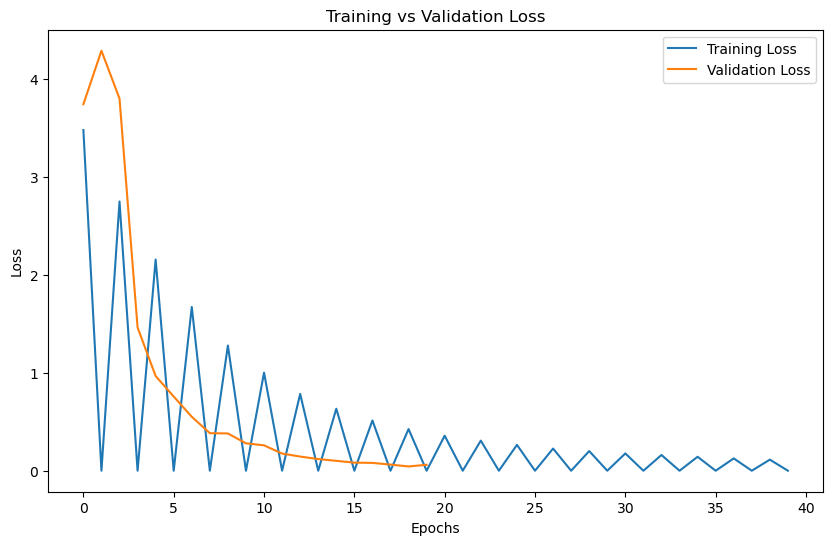

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


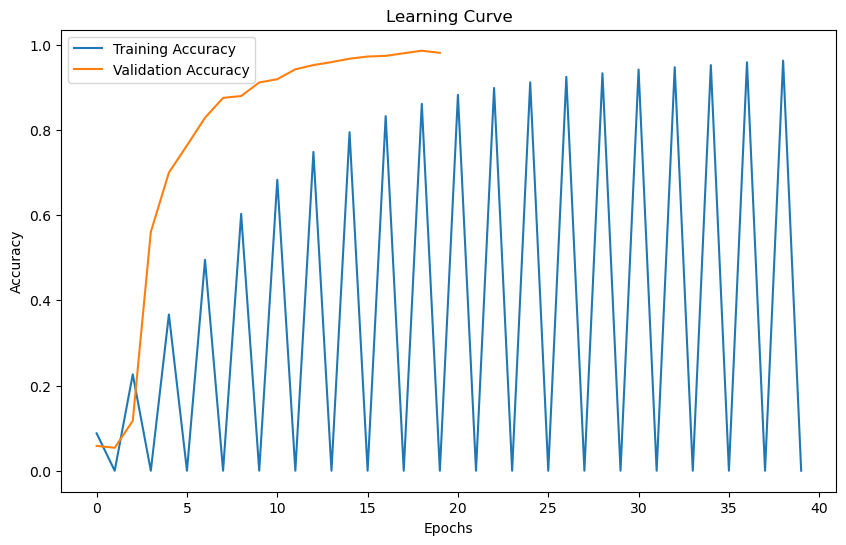

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()


In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_val_true, y_val_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [ ]:
from sklearn.calibration import calibration_curve

y_prob = model.predict(val_generator)  # Get prediction probabilities
prob_true, prob_pred = calibration_curve(y_val_true, y_prob[:, 1], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.title('Calibration Curve')
plt.show()


In [ ]:
tta_predictions = []
for _ in range(10):  # Number of augmentations
    test_augmented = test_datagen.flow_from_directory(test_dir, shuffle=False, batch_size=batch_size)
    tta_predictions.append(model.predict(test_augmented))

# Average predictions
tta_predictions = np.mean(tta_predictions, axis=0)
tta_pred_classes = np.argmax(tta_predictions, axis=1)


In [ ]:
import matplotlib.pyplot as plt

# Find misclassified indices
misclassified_indices = np.where(y_val_true != y_val_pred)[0]

# Visualize a few misclassified examples
for idx in misclassified_indices[:5]:  # Display 5 misclassified examples
    img, label = val_generator[idx]  # Load misclassified image and label
    plt.imshow(img[0])  # Assuming `val_generator` yields batches
    plt.title(f"True: {label}, Pred: {y_val_pred[idx]}")
    plt.show()


In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Get true labels and predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)

# Calculate RMSE for the predictions
rmse = np.sqrt(mean_squared_error(y_true, np.argmax(y_pred, axis=1)))

print(f"RMSE: {rmse}")


408/408 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step
RMSE: 0.948764067987917


In [32]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to calculate RMSE
def calculate_rmse(generator, model):
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot to class index
        y_pred_batch = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(y_pred_batch, axis=1))  # Convert probabilities to class index

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Calculate RMSE for training and validation datasets
train_rmse = calculate_rmse(train_generator, model)
val_rmse = calculate_rmse(val_generator, model)

# Print RMSE results
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")


Training RMSE: 1.1069
Validation RMSE: 0.9312


In [35]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Function to calculate RMSE
def calculate_rmse(generator, model):
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot to class index
        y_pred_batch = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(y_pred_batch, axis=1))  # Convert probabilities to class index

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

# Calculate RMSE for training and validation datasets
train_rmse = calculate_rmse(train_generator, model)
val_rmse = calculate_rmse(val_generator, model)

# Print RMSE results
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")


Training RMSE: 1.1789
Validation RMSE: 0.9312
